# Exercise 03
**Kernel Methods in Machine Learning (CS-E4830)**

**Tutorial session: 12th May at 16:15-18:00** 

**Submission deadline : 19th May at 4pm**

<div class="alert alert-success">
    <b>Tasks:</b>

1. [Support Vector Machines (SVM)](#csvm)
  1. [Dual optimization using quadratic programming (QP)](#task_1) (**2 Points**)
  2. [Comparison to LibSVM](#task_2) (**2 Point**)
  3. [Visualize Support Vectors](#visual_sv)
2. [Non-linear Kernels](#non_linear_kernels)
  1. [Tanimoto kernel for binary data](#tanimoto_kernel) (**2 Point**)
  2. [MinMax kernel for non-negative data](#minmax_kernel) (**1 Point**)
  3. [Toxicity Prediction using Non-Linear SVM](#toxicity_prediction) (**1 Point**)
</div> 

**Version**: 1.3

**Version history**:

- 1.0: Initial version
- 1.1: Modify SVM class: For $|\alpha_i - C| < \epsilon$ we set $\alpha_i = C$. This fix improves the numerical stability of the SVM [bias $b$ estimation](#bias).
- 1.2: Minor changes: Fix doc-string of ```decision_function```, rename ```self._ytrain``` to ```self._y_train``` in ```__init__```, and indicate what is the [*bias constraint*](#SVM_dual)

<div class="alert alert-danger">
    Please add you student number and email address to the notebook into the corresponding cell.
</div>    

EMAIL: xin.1.sun@aalto.fi

STUDENT_NUMBER: 896159

In [1]:
import time

import numpy as np
import scipy.optimize as spopt
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.svm import SVC as SVM_sk
from sklearn.datasets import make_blobs, make_moons
from sklearn.metrics.pairwise import rbf_kernel as rbf_kernel_sk
from sklearn.metrics.pairwise import linear_kernel as linear_kernel_sk

In [2]:
def gaussian_kernel_wrapper(X, Y=None, sigma=None):
    """
    Wrapper around the sklearn rbf-kernel function. It converts between the
    gamma parametrization (sklearn) and the sigma parametrization (lecture).
    """
    if sigma is None:
        sigma = np.sqrt(X.shape[1] / 2.)

    return rbf_kernel_sk(X, Y, gamma=(1. / (2. * (sigma**2))))

In [3]:
def plot_svm_model(X, y, svm, ax=None, show_origin=False, verbose=True):
    """
    Helper function to plot svm models for simple 2D-data.
    """
    # Fit model
    svm.fit(X, y)
    
    if verbose:
        if isinstance(svm, SVM_sk):
            print("Number of support vectors:", svm.n_support_)
            print("Bias:", np.round(svm.intercept_, 4))
        else:
            print("Number of support vectors:", svm.n_sv)
            print("Bias:", np.round(svm._bias, 4))
            print("Dual variables:\n", np.round(svm._alpha[svm._alpha > 0], 4))

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    _ = ax.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", s=50, label="positive class")
    _ = ax.scatter(X[y == -1, 0], X[y == -1, 1], c="red", s=50, label="negative class")

    # plot the decision function
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    if show_origin:
        xlim = (np.minimum(-0.5, xlim[0]), np.maximum(0.5, xlim[1]))
        ylim = (np.minimum(-0.5, ylim[0]), np.maximum(0.5, ylim[1]))
        
        ax.plot(0, 0, 's', c="k", label="Origin")

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = svm.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    _ = ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, 
                   linestyles=['--', '-', '--'])
    # plot support vectors
    _ = ax.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], s=200,
                   linewidth=1.5, facecolors='none', edgecolors='k', label="Support vectors")
    _ = ax.legend()
    
    _ = ax.grid()

## 1. C - Support Vector Machine (C-SVM) <a id='csvm'></a>

In this task you are going to implement a soft-margin C-SVM. You will use the dual formulation (derived in the Pen & Paper exercise) to find the optimal model using quadratic programming (QP).

#### SciPy Optimization Toolbox

A convenient interface to a QP-solver is provided by the [scipy.optimization](https://docs.scipy.org/doc/scipy-1.1.0/reference/optimize.html) package (JupyterHub uses version 1.1.0). As optimization algorithm we will use  [Sequential Least SQuares Programming (SLSQP)](https://neos-guide.org/content/sequential-quadratic-programming) (```scipy.optimize.minimize(..., method="SLSQP")```). Another popular framework for optimization in Python is, e.g., [cvxpy](https://www.cvxpy.org/) (not available on JupyterHub).

#### SVM Primal formulation

For a given training set $\{(\mathbf{x}_i,y_i)\}_{i=1}^{n_{train}}$, the C-SVM formulation is given as:

\begin{align}
\underset{\mathbf{w},\boldsymbol{\xi},b}{\min}&\,\frac{1}{2}\|\mathbf{w}\|^2 + C \sum_{i=1}^{n_{train}}\xi_i \\
\text{s.t.}&\,y_i(\mathbf{w}^T\phi(\mathbf{x}_i))+b)\geq 1-\xi_i\\
&\,\xi_i\geq 0,\quad i=1,\ldots,n_{train},
\end{align}

where $\mathbf{w}\in\mathbb{R}^d$ are the model parameters, and $b\in\mathbb{R}$ is the bias, and $\boldsymbol{\xi}\in\mathbb{R}_{\geq0}^{n_{train}}$ is the vector of slack-variables, and $C>0\in\mathbb{R}$ is the regularization parameter. 

The primal C-SVM **decision function** is given as:

$$
f(\mathbf{x})=\mathbf{w}^T\phi(\mathbf{x})+b\in\mathbb{R}
$$

and the corresponding **prediction function** as: 

$$
g(\mathbf{x})=sign(f(\mathbf{x}))\in\{-1,1\}.
$$

#### SVM Dual formulation <a id='SVM_dual'></a>

In the Pen & Paper exercise you showed, that the dual C-SVM can be written as:

\begin{align}
\underset{\boldsymbol{\alpha}}{\max}&\,\mathcal{L}(\boldsymbol{\alpha})=\underbrace{\sum_{i=1}^{n_{train}}\alpha_i - \frac{1}{2}\sum_{i=1}^{n_{train}}\sum_{j=1}^{n_{train}}\alpha_i\alpha_j y_i y_j \kappa(\mathbf{x}_i,\mathbf{x}_j)}_{\text{Loss function}}\\
\text{s.t.}&\,0\leq\alpha_i\leq C,\quad i=1,\ldots,n_{train} \\
&\,\underbrace{\sum_{i=1}^{n_{train}}\alpha_i y_i=0}_{\text{Bias constraint}},
\end{align}

or, equivalent in matrix notation, as:

\begin{align}
\underset{\boldsymbol{\alpha}}{\max}&\,\mathbf{1}^T\boldsymbol{\alpha} - \frac{1}{2}\boldsymbol{\alpha}^T\left(\mathbf{y}\mathbf{y}^T\circ\mathbf{K}\right)\boldsymbol{\alpha}\\
\text{s.t.}&\,0\leq\alpha_i\leq C,\quad i=1,\ldots,n_{train} \\
&\,\boldsymbol{\alpha}^T\mathbf{y}=0,
\end{align}

where $\boldsymbol{\alpha}\in\mathbb{R}^{n_{train}}$ are the dual variables, and $\mathbf{K}\in\mathbb{R}^{n_{train}\times n_{train}}$ is the training kernel matrix (with $[\mathbf{K}]_{ij}=\kappa(\mathbf{x}_i,\mathbf{x}_j)=\phi(\mathbf{x}_i)^T\phi(\mathbf{x}_j)$), and $\mathbf{y}\in\{-1,1\}^{n_{train}}$ training labels, and $C>0\in\mathbb{R}$ being the regularisation parameter. Let us furthermore define the shorthand: $\mathbf{G}=\mathbf{y}\mathbf{y}^T\circ\mathbf{K}$.

##### Support Vector (SV) <a id='SV'></a>

The training examples $\mathbf{x}_i$ (respectively their feature vectors $\phi(\mathbf{x}_i)$) for which $\alpha_i>0$ are called **support vectors (SV)**. The examples $\mathbf{x}_i$ for which *additionally* holds $\alpha_i<C$ are the SVs **on the margin**. For convenience let us define $\mathcal{I}_S$ being the index set of the support vectors and $\mathcal{I}_M$ being the index set of the support vectors on the margin.
##### Dual C-SVM **decision function**

The Dual C-SVM decision function for a new exmaple $\mathbf{x}$ can be written as:

$$
f(\mathbf{x})=\left(\sum_{i=1}^{n_{train}}\alpha_i y_i \kappa(\mathbf{x},\mathbf{x}_i)\right)+b=\left(\sum_{i\in\mathcal{I}_{S}}\alpha_i y_i \kappa(\mathbf{x},\mathbf{x}_i)\right)+b\in\mathbb{R}
$$

or, equivalent in matrix notation, as:

$$
f(\mathbf{x})=\left(\mathbf{y}[\mathcal{I}_S]\circ\boldsymbol{\alpha}[\mathcal{I}_S]\right)^T\mathbf{k}(\mathbf{x})[\mathcal{I}_S] + b,
$$

with $z[\cdot]$ element access similar to numpy, and $\mathbf{k}(\mathbf{x})=[\kappa(\mathbf{x},\mathbf{x}_1),\ldots,\kappa(\mathbf{x},\mathbf{x}_{n_{train}})]\in\mathbb{R}^{n_{train}}$ are the kernel values between the new and the training examples.

#### Estimating the Bias-term $b$ <a id='bias'></a>

For the SVs on the margin we know that $\xi_i=0$ and therefore that $y_i f(\mathbf{x}_i)=1$. We can therefore calculate $b$ for a given $\boldsymbol{\alpha}$ using:

$$
    b = \frac{1}{|\mathcal{I}_M|}\sum_{i\in\mathcal{I}_M}\left(y_i - \sum_{j\in\mathcal{I}_s} y_j\alpha_j\kappa(\mathbf{x}_i, \mathbf{x}_j)\right)
$$

or, equivalent in matrix notation:

$$
    b = \frac{1}{|\mathcal{I}_M|}\mathbf{1}^T\left(\mathbf{y}[\mathcal{I}_M]-\mathbf{K}[\mathcal{I}_M][:, \mathcal{I}_S]\left(\mathbf{y}[\mathcal{I}_S]\circ\boldsymbol{\alpha}[\mathcal{I}_S]\right)\right).
$$

For further details, check out ["Pattern Recognition and Machine Learning" book by C. Bishop](https://www.microsoft.com/en-us/research/people/cmbishop/#!prml-book) (p. 333-334).

### A. Dual optimization using quadratic programming (QP) (**2 Points**) <a id='task_1'></a>
<div class="alert alert-success">
    <b>Task:</b>
    Implement missing code parts of the SVM class. You have to modify the following member-functions:
    
- ```_loss_and_grad```: This function should return the loss function value $\mathcal{L}(\boldsymbol{\alpha})$ for a given $\boldsymbol{\alpha}$ vector and the gradient $\nabla_{\boldsymbol{\alpha}}\mathcal{L}$ of the loss function.
- ```_calculate_bias```: This function should return the bias calculated as [presented](#bias). Keep the [support vector definitions](#SV) in mind.
- ```fit```: In this function you need to define the $\mathbf{G}$ matrix, the box and linear constraints (*s.t.*) and run the optimizer.
- ```decision_function``` and ```predict```: This functions should implement the functions $f(\mathbf{x})$ and $g(\mathbf{x})$.
</div>

<div class="alert alert-warning">
    <b>Hints / Notes:</b> 
    
- There are online tools existing to check your derived gradients, e.g. [matrixcalculus.org](http://www.matrixcalculus.org/).
- Make your self familiar with the [```scipy.optimize.minimize```](https://docs.scipy.org/doc/scipy-1.1.0/reference/generated/scipy.optimize.minimize.html) function.
- Read how to define [box- (bounds)](https://docs.scipy.org/doc/scipy-1.1.0/reference/generated/scipy.optimize.Bounds.html#scipy.optimize.Bounds) and linear-constraints?
- The dual loss function $\mathcal{L}$ can be maximized by minimizing $-\mathcal{L}$. Scipy only implements a minimize function.
- [Visualizinf your model](#visualize_svm_model) might help you debugging it.
- Instead of the index sets $\mathcal{I}_M$ and $\mathcal{I}_S$, the implementation works with indicator vectors, e.g. ```_is_sv```$ =\{True,False\}^{n_{train}}$ with ```_is_sv[i]``` = $\alpha_i>0$.
</div>

In [12]:
class SVM(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1., alpha_threshold=1e-6, sigma=None, kernel="gaussian", verbose=True):
        """
        C - Support Vector Machine (SVM)
        
        :param C: scalar, regularization parameter C (default = 1)
        :param alpha_threshold: scalar, threshold to set the dual variables to zero if very
            small (e.g. due to numerical optimization) (default = 1e-6)
        :param sigma: scalar, sigma parameter used for the gaussian kernel (default = None)
        :param kernel: {string, calaable}, name of the kernel to use or function to
            calculate the kernel matrices (defualt = "gaussian")
        :param verbose: boolean, indicating whether some performance / debugging information
            should be plotted
        """
        # Optimization parameters
        self.C = C 
        self._alpha_threshold = alpha_threshold
        self._verbose = verbose
        
        # Model parameters
        self._alpha = None      # dual variables alpha_i
        self._bias = None       # bias term
        self._X_train = None    # training feature vectors needed for prediction
        self._y_train = None     # training labels
        
        # Support vector information
        self._is_sv = None            # indicator vector, which example is support vector
        self.n_sv = None              # number of support vectors per class
        self.support_vectors_ = None  # Support vector input feature vectors 
        
        # Kernel parameters
        self.kernel = kernel
        self.sigma = sigma
        
    def _loss_and_grad(self, alpha, G, sign=-1):
        """
        Calculate the SVM dual loss function and its corresponding gradient.
        
        :param alpha: array-like, shape=(n_train, ), current dual variable vector
        :param G: array-like, shape=(n_train, n_train), G_train matrix 
        :param sign: scalar, sign of the loss and gradient, should be 1 for minimization and 
            -1 for maximization (default = -1)
            
        :return tuple=(loss function value, gradient vector [shape=(n_train,)])
        """
        # YOUR CODE HERE
        loss_value = np.sum(alpha) - 0.5*alpha.T @ G @alpha
        gradient_vector = np.ones((len(alpha,))) - 0.5 * (G + G.T) @ alpha
        
#         return sign*loss, sign*grad
#         raise NotImplementedError()

        return sign * loss_value, sign * gradient_vector
    
    def _calculate_bias(self, K_train, y_train, alpha, is_sv):
        """
        Function to determine the bias term after the dual variables have been optimized.
        
        :param K_train: array-like, shape=(n_train, n_train), training kernel matrix
        :param y_train: array-like, shape=(n_train, 1), training labels
        :param alpha: array-like, shape=(n_train,), dual variables
        :param is_sv: array-like, shape=(n_train,), boolean vector indicating whether a 
            training example is a support vector or not, i.e. is_cv[i] == True => alpha[i] > 0 
        
        :return: scalar, bias
        """
        # Get indicator vector of the support vectors on the margin, 
        # i.e. for which slack_i = 0.
        is_sv_mrg = np.bitwise_and(is_sv, (alpha < self.C).flatten())
        
        # Calculate the bias according to the formula. 
        # YOUR CODE HERE
        bias = 1/sum(is_sv_mrg) * np.ones((sum(is_sv_mrg==True),)) @ (y_train[is_sv_mrg] - K_train[is_sv_mrg][:,is_sv] @ (y_train[is_sv] * alpha[is_sv]))
#         raise NotImplementedError()
         
        return bias
        
    def fit(self, X_train, y_train):
        """
        Fit the SVM model parameters
        
        :param X_train: array-like, shape=(n_train, n_features), training feature matrix
        :param y_train: array-like, shape=(ntrain, ) or (n_train, 1), training labels, {-1, 1}
        
        :return: reference to it self
        """
        self._X_train = X_train
        K_train = self._get_kernel(self._X_train)
        n_train = K_train.shape[0]  # number of training examples
        
        # Make training labels beeing a column-vector
        self._y_train = y_train
        if len(self._y_train.shape) == 1:
            self._y_train = self._y_train[:, np.newaxis]
        
        # Calculate the matrix: G_train = yy' .* K_train
        # YOUR CODE HERE
        G_train = self._y_train@self._y_train.T * K_train
#         raise NotImplementedError()
        
        # Set up the equality contraint introduced by the bias-term: bias_const
        # YOUR CODE HERE
        def cons(a):
            return a.T @ self._y_train
        bias_const = {'type':'eq','fun':cons}
#         raise NotImplementedError()
        
        assert (isinstance(bias_const, dict) and \
                "type" in bias_const and \
                "fun" in bias_const), \
            "bias_const must be specified as dictionary. See hints."
        assert (callable(bias_const["fun"])), "Provide a function to evalute the constraint."
        
        # Define the bounds (0 <= alpha_i <= C) for the dual varaibles: bound_const
        # YOUR CODE HERE
        bounds_const = spopt.Bounds(0, self.C)
#         raise NotImplementedError()
        
        assert (isinstance(bounds_const, spopt.Bounds))
        
        # Define a feasiable initial value for the dual variables: 
        # 0 <= alpha0_i <= C, y^T alpha0_i = 0
        # YOUR CODE HERE
        alpha0 = np.zeros((len(y_train),))
#         raise NotImplementedError()
        
        assert (alpha0.shape == (n_train, )), "alpha0 must have shape=(n_train,)."
        assert (all(alpha0 >= 0) and all(alpha0 <= self.C) and (self._y_train.T @ alpha0 == 0)), \
            "alpha0 must be feasible."
        
        if self._verbose:
            start = time.time()
        
        # Run the optimizer
        res = spopt.minimize(self._loss_and_grad, x0=alpha0, jac=True, args=(G_train, ),
                             method="SLSQP", constraints=bias_const, bounds=bounds_const)
        
        if self._verbose:
            print("Optimizing time: %.3fs" % (time.time() - start))
        
        # Extract the optimal dual varaibles (solution) from the optimizer
        self._alpha = res["x"][:, np.newaxis]
        
        # Threshold alpha values to zero if very small
        self._alpha[self._alpha < self._alpha_threshold] = 0
        self._alpha[np.abs(self._alpha - self.C) < self._alpha_threshold] = self.C
        
        # Find support vectors (alpha_i > 0)
        # YOUR CODE HERE
        self._is_sv = (self._alpha > 0).reshape((len(self._alpha),))
#         raise NotImplementedError()
        
        assert (self._is_sv.shape == (n_train, )), \
            "_is_sv must be an indicator vector with shape=(n_train, )."
        
        self.support_vectors_ = X_train[self._is_sv]
        
        # Get number of support vectors per class
        self.n_sv = np.array([np.sum(self._is_sv[y_train.flatten() == -1]),
                              np.sum(self._is_sv[y_train.flatten() ==  1])])
        
        # Calcualte the bias
        self._bias = self._calculate_bias(K_train, self._y_train, self._alpha, self._is_sv)
        
        return self
    
    def decision_function(self, X):
        """
        Calculate decision function:
            f(x) = sum_i y_i alpha_i k(x_i, x) + bias

        :param X: array-like, shape=(n_test, n_features), 
        :return: array-like, shape=(n_test, ), decision function value f(x) for all test 
            samples
        """
        # Calculate the test-training kernel shape=(n_test, n_train)
        K_test_train = self._get_kernel(X, self._X_train)
        
        # Calculate the decision function values (only using SV)
        # YOUR CODE HERE
        g_X = K_test_train[:,self._is_sv] @(self._y_train[self._is_sv] * self._alpha[self._is_sv]) + self._bias
#         raise NotImplementedError()
        
        # reduce to 1d vector
        g_X = g_X.flatten()
        
        # check output dimension
        assert (g_X.shape == (X.shape[0], )), \
            "Output of the decision function must have shape: (n_test, )"
        
        return g_X
        
    def predict(self, X):
        """
        Predict labels using C-SVM:
            g(x) = sign(f(x)), with f(x) being the decision function

        :param X: array-like, shape=(n_test, n_features), test feature matrix
        :return: array-like, shape=(n_test,), predicted labels {-1, 1} for all test samples
        """
        # YOUR CODE HERE
        y_X = np.sign(self.decision_function(X))
#         raise NotImplementedError()
        
        assert ((np.in1d(y_X, [-1, 0, 1]).all())), \
            "Output of the prediction function must be {-1, 0, 1}"
        
        return y_X
    
    def _get_kernel(self, X, Y=None):
        """
        Caculate kernel matrix using specified kernel-function and parameters.

        :param X: array-like, shape=(n_samples_A, n_features), feature-matrix of set A
        :param Y: array-like, shape=(n_samples_B, n_features), feature-matrix of set B
            or None, than Y = X
        :return: array-like, shape=(n_samples_A, n_samples_B), kernel matrix
        """
        if self.kernel == "gaussian":
            return gaussian_kernel_wrapper(X, Y, self.sigma)
        elif self.kernel == "linear":
            return linear_kernel_sk(X, Y)
        elif callable(self.kernel):
            return self.kernel(X, Y)
        else:
            raise ValueError("Invalid kernel chosen.")

##### Tests for the ```_loss_and_grad``` Function

In [13]:
# Tests for the loss & gradient function 

# Very simple data
# __X = np.array([[0, 1], [-1, 0], [0, -1], [1, 0]]) 
# __y = np.array([1, 1, -1, -1])

# Linear kernel
__G = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [1, 0, 1, 0], [0, 1, 0, 1]])  # assume linear K
__alpha = np.full((4, ), 0.5)
__loss_val, __grad_vec = SVM(C=1.)._loss_and_grad(__alpha, __G)

assert (np.isscalar(__loss_val)), "Loss value must be a scalar."
assert (__grad_vec.shape == __alpha.shape), "Gradient vector must have same length as alpha."

np.testing.assert_allclose(__loss_val, - (2. - 0.5 * 2.),
                           err_msg="Loss value is wrong.")  # remember the negative sign of loss
np.testing.assert_allclose(__grad_vec, np.zeros((4, )), 
                           err_msg="Gradient vector is wrong.")

# Gaussian kernel
__G = np.array([[ 1.   ,  0.368,  0.135,  0.368],
                [ 0.368,  1.   ,  0.368,  0.135],
                [ 0.135,  0.368,  1.   ,  0.368],
                [ 0.368,  0.135,  0.368,  1.   ]])  # assume gaussian K
__alpha = np.ones((4, ))
__loss_val, __grad_vec = SVM(C=1., kernel="gaussian")._loss_and_grad(__alpha, __G)

np.testing.assert_allclose(__loss_val, - (4. - 0.5 * 7.484),
                           err_msg="Loss value is wrong.")  # remember the negative sign of loss
np.testing.assert_allclose(__grad_vec, np.full((4, ), 0.871),
                           err_msg="Gradient vector is wrong.")


##### Tests for the ```_calculate_bias``` Function

In [14]:
# Test for the bias calculation

# Simple data (linear separable)
__X = np.array([[-1, 0], [0, 1], [-.75, .75], [0, -1], [1, 0]])
__y = np.array([1, 1, 1, -1, -1])
__C = 10.

# Get dual variable vector using the sklearn SVM
__svm_sk = SVM_sk(C=__C, kernel="linear").fit(__X, __y)
__alpha = np.zeros((__X.shape[0], ))
# Note: Sklearn stores only dual_coef_i = alpha_i * y_i
__alpha[__svm_sk.support_] = __svm_sk.dual_coef_ * __y[__svm_sk.support_]  

# Determine support vectors
__is_sv = (__alpha > 0)

# Calculate the bias
__bias = SVM(C=__C, kernel="linear")._calculate_bias(linear_kernel_sk(__X), __y, 
                                                     __alpha, __is_sv)
np.testing.assert_array_equal(__bias, __svm_sk.intercept_, err_msg="Bias term is not correct.")

# Simple data (linear separable): shifted data
# Get dual variable vector using the sklearn SVM
__X += np.array([-1., 1.])
__svm_sk = SVM_sk(C=__C, kernel="linear").fit(__X, __y)
__alpha = np.zeros((__X.shape[0], ))
__alpha[__svm_sk.support_] = __svm_sk.dual_coef_ * __y[__svm_sk.support_]

# Determine support vectors
__is_sv = (__alpha > 0)

# Calculate the bias
__bias = SVM(C=__C, kernel="linear")._calculate_bias(linear_kernel_sk(__X), 
                                                     __y, __alpha, __is_sv)
np.testing.assert_array_equal(__bias, __svm_sk.intercept_, err_msg="Bias term is not correct.")

# Simple data (not separable)
__X = np.array([[-1, 0], [0, 1], [.75, -.75], [0, -1], [1, 0]]) + np.array([-1., 1.])
__y = np.array([1, 1, 1, -1, -1])
__C = 10.

# Get dual variable vector using the sklearn SVM
__svm_sk = SVM_sk(C=__C, kernel="linear").fit(__X, __y)
__alpha = np.zeros((__X.shape[0], ))
__alpha[__svm_sk.support_] = __svm_sk.dual_coef_ * __y[__svm_sk.support_]

# Determine support vectors
__is_sv = (__alpha > 0)

# Calculate the bias
__bias = SVM(C=__C, kernel="linear")._calculate_bias(linear_kernel_sk(__X), __y,
                                                     __alpha, __is_sv)
np.testing.assert_allclose(__bias, __svm_sk.intercept_, 
                           err_msg="Bias term is not correct.", atol=1e-6)


#### Visual Inspection of your C-SVM Implementation <a id='visualize_svm_model'></a>

Here we run a small classification problem, that is linearly seperable. The example is taken from the sklearn-package [Maximum margin separating hyperplane example](https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html). Your model should have *three* support vectors (one red -, two blue +). Your estimated bias should $b=-3.2145$ and your dual variables (of the support vectors, i.e. $\alpha_i > 0$) $\boldsymbol{\alpha}=[0.3834, 0.2537, 0.1297]^T$. 

<div class="alert alert-warning">
    <b>Note:</b>  Here for first time we actually run to optimizer. So if anything goes wrong, check that, e.g., your constraints are set up correctly and your prediction functions are outputting the right format.
</div>

Number of support vectors: [1 2]
Bias: [-3.2145]
Dual variables:
 [0.3834 0.2537 0.1297]


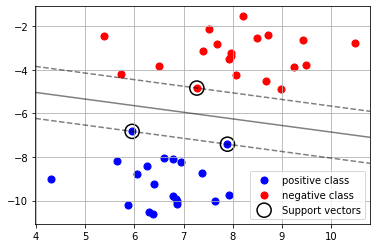

In [15]:
# Create some very simple test data
X, y = make_blobs(n_samples=40, centers=2, random_state=6)
y[y==0] = -1
plot_svm_model(X, y, SVM(C=1, kernel="linear", verbose=False))

### B. Comparison to Sklearn SVM (libSVM) (2 Point) <a id='task_2'></a>

In this task your SVM implementation will be applied on two artificial datasets (see also exericse 1) and compared with the performance of the [sklearn SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) implementation. Sklearn uses [libSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvm/) as solver in the background. If you are interested in SVM solver implementation details, you can read the [libSVM manual](https://www.csie.ntu.edu.tw/~cjlin/papers/libsvm.pdf). 

<div class="alert alert-success">
    <b>Task:</b> Your SVM implentation is applied here, i.e. do <b>not need</b> to write additional code. Simply run tests in the next cell. It will test all the functionality of your SVM class. Revise your implementation in case some tests fail.
</div>

In [16]:
# Test implementation agains sklearn
__X_blobs, __y_blobs = make_blobs(n_samples=350, centers=[[1, 1], [3, 3]],
                                  cluster_std=[0.5, 1.15], random_state=202)
__X_moons, __y_moons = make_moons(n_samples=350, noise=0.25, random_state=212)

# Make labels being {-1, 1}
__y_blobs[__y_blobs==0] = -1
__y_moons[__y_moons==0] = -1

# Split data
__X_blobs_train, __X_blobs_test, __y_blobs_train, __y_blobs_test = train_test_split(
    __X_blobs, __y_blobs, random_state=191)
__X_moons_train, __X_moons_test, __y_moons_train, __y_moons_test = train_test_split(
    __X_moons, __y_moons, random_state=881)

# Blobs
print("Blobs:", end="\n\t")
__svm_sk = SVM_sk(C=2., kernel="rbf", gamma="auto").fit(__X_blobs_train, __y_blobs_train)
__svm = SVM(C=2., kernel="gaussian").fit(__X_blobs_train, __y_blobs_train)

print("\tTest score (sklearn, scipy):", 
      np.round(__svm_sk.score(__X_blobs_test, __y_blobs_test), 3), 
      np.round(__svm.score(__X_blobs_test, __y_blobs_test), 3))
print("\tN_sv (sklearn, scipy):", __svm_sk.n_support_, __svm.n_sv)
print("\tBias (sklearn, scipy):", np.round(__svm_sk.intercept_, 3), np.round(__svm._bias, 3))

np.testing.assert_allclose(__svm.score(__X_blobs_test, __y_blobs_test), 
                           __svm_sk.score(__X_blobs_test, __y_blobs_test), 
                           err_msg="Blobs: Test set accuracies differ too much.")
np.testing.assert_equal(__svm.n_sv, __svm_sk.n_support_,
                        err_msg="Moons: Number of support vectors does not match.")
np.testing.assert_allclose(__svm._bias, __svm_sk.intercept_, atol=1e-2, 
                           err_msg="Blobs: Bias values differ too much.")

# Moons
print("Moons:", end="\n\t")
__svm_sk = SVM_sk(C=2., kernel="rbf", gamma="auto").fit(__X_moons_train, __y_moons_train)
__svm = SVM(C=2., kernel="gaussian").fit(__X_moons_train, __y_moons_train)

print("\tTest score (sklearn, scipy):", 
      np.round(__svm_sk.score(__X_moons_test, __y_moons_test), 3), 
      np.round(__svm.score(__X_moons_test, __y_moons_test), 3))
print("\tN_sv (sklearn, scipy):", __svm_sk.n_support_, __svm.n_sv)
print("\tBias (sklearn, scipy):", np.round(__svm_sk.intercept_, 3), np.round(__svm._bias, 3))

np.testing.assert_allclose(__svm.score(__X_moons_test, __y_moons_test), 
                           __svm_sk.score(__X_moons_test, __y_moons_test), 
                           err_msg="Moons: Test set accuracies differ too much.")
np.testing.assert_equal(__svm.n_sv, __svm_sk.n_support_, 
                        err_msg="Moons: Number of support vectors does not match.")
np.testing.assert_allclose(__svm._bias, __svm_sk.intercept_, atol=1e-2, 
                           err_msg="Moons: Bias values differ too much.")

Blobs:
	Optimizing time: 4.627s
	Test score (sklearn, scipy): 0.966 0.966
	N_sv (sklearn, scipy): [14 23] [14 23]
	Bias (sklearn, scipy): [0.624] [0.624]
Moons:
	Optimizing time: 4.333s
	Test score (sklearn, scipy): 0.932 0.932
	N_sv (sklearn, scipy): [41 40] [41 40]
	Bias (sklearn, scipy): [0.081] [0.082]


### C. Visualization of the Model and Support Vectors <a id='visual_sv'></a>

In [17]:
# Create synthetic data (Please do not change the random_state!)
X_blobs, y_blobs = make_blobs(n_samples=250, centers=[[1, 1], [3, 3]], cluster_std=[0.5, 1.15], random_state=202)
X_moons, y_moons = make_moons(n_samples=250, noise=0.25, random_state=211)
# Make labels being {-1, 1}
y_blobs[y_blobs==0] = -1
y_moons[y_moons==0] = -1

# Split data
X_blobs_train, X_blobs_test, y_blobs_train, y_blobs_test = train_test_split(X_blobs, y_blobs, random_state=191)
X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(X_moons, y_moons, random_state=881)

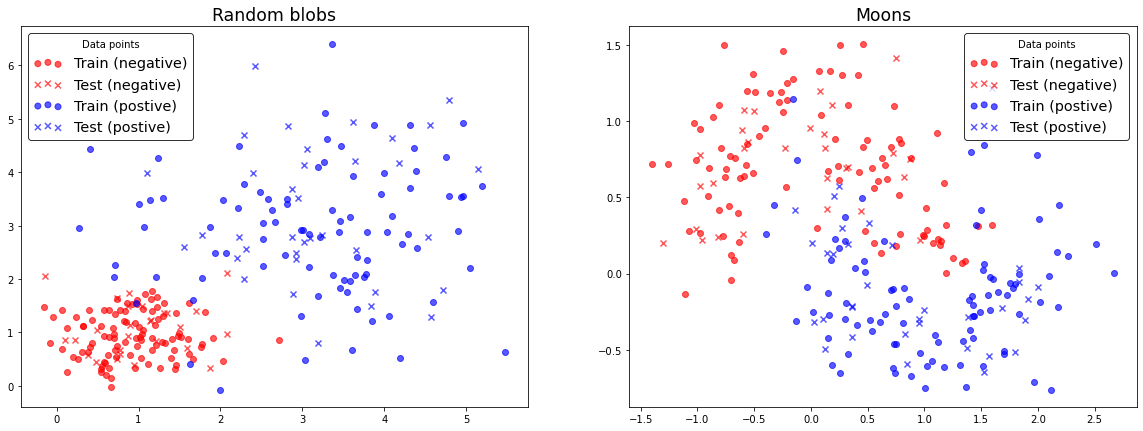

In [18]:
# Plot datasets
fig, axrr = plt.subplots(1, 2, figsize=(20, 7))

# Blobs
for l_str, l_num, col in [("negative", -1, "red"), ("postive", 1, "blue")]:    
    axrr[0].scatter(
        X_blobs_train[y_blobs_train==l_num, 0], X_blobs_train[y_blobs_train==l_num, 1],
        c=col, alpha=0.65, label="Train (%s)" % l_str)
    
    axrr[0].scatter(
        X_blobs_test[y_blobs_test==l_num, 0], X_blobs_test[y_blobs_test==l_num, 1],
        c=col, alpha=0.65, label="Test (%s)" % l_str, marker="x")
        
# Blobs
for l_str, l_num, col in [("negative", -1, "red"), ("postive", 1, "blue")]:    
    axrr[1].scatter(
        X_moons_train[y_moons_train==l_num, 0], X_moons_train[y_moons_train==l_num, 1],
        c=col, alpha=0.65, label="Train (%s)" % l_str)
    
    axrr[1].scatter(
        X_moons_test[y_moons_test==l_num, 0], X_moons_test[y_moons_test==l_num, 1],
        c=col, alpha=0.65, label="Test (%s)" % l_str, marker="x")


axrr[0].set_title("Random blobs", fontsize="xx-large")
axrr[0].legend(title="Data points", fontsize="x-large", scatterpoints=3, edgecolor="k")

axrr[1].set_title("Moons", fontsize="xx-large")
axrr[1].legend(title="Data points", fontsize="x-large", scatterpoints=3, edgecolor="k")

plt.show()

Optimizing time: 0.857s
Optimizing time: 1.229s
Optimizing time: 1.302s
Optimizing time: 1.634s


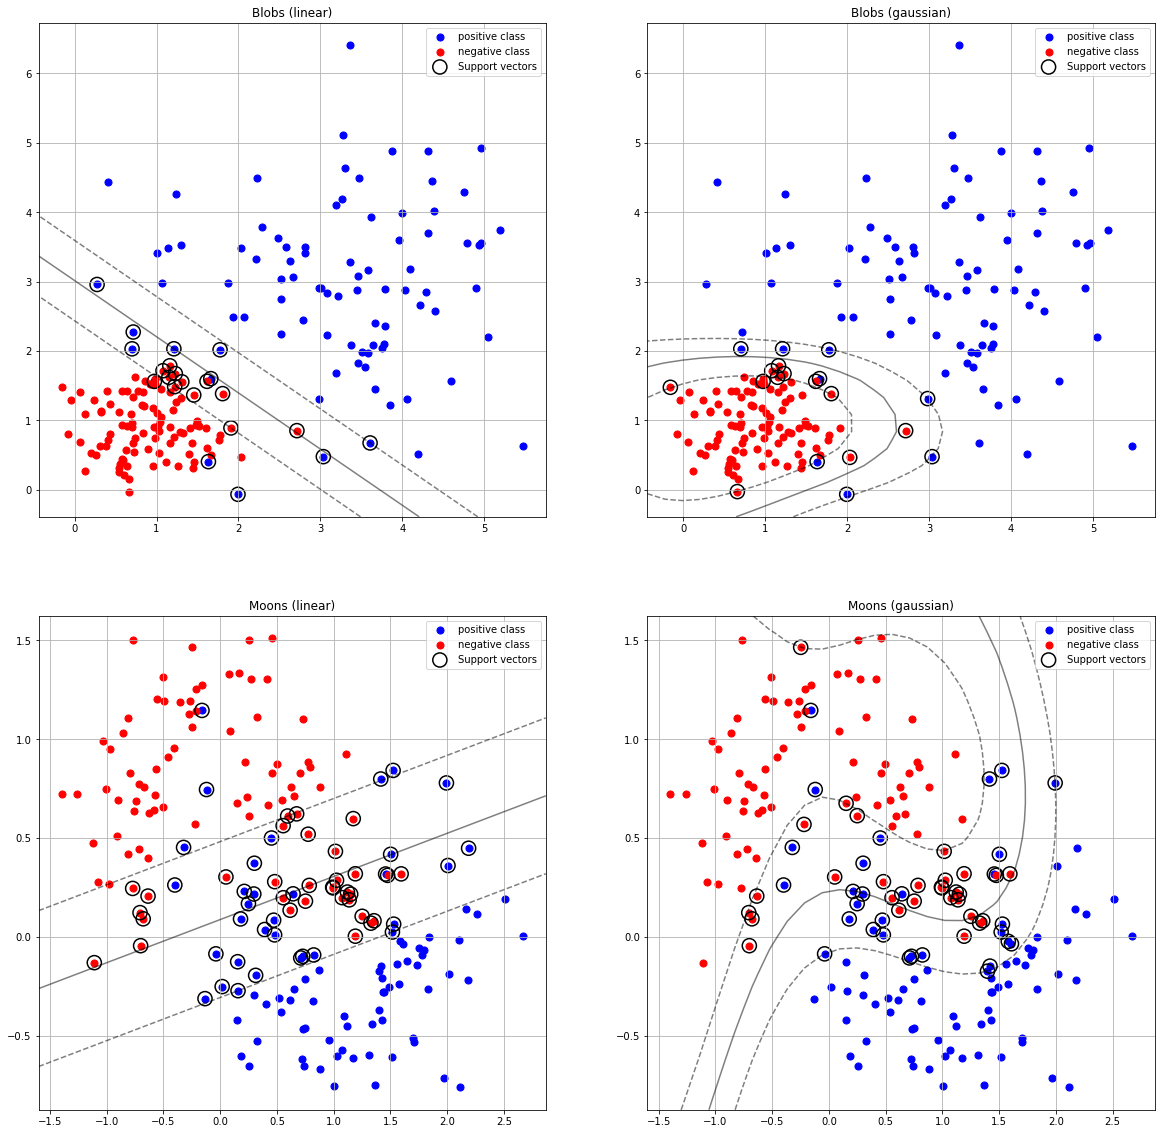

In [19]:
fig, axrr = plt.subplots(2, 2, figsize=(20, 20))
plot_svm_model(X_blobs_train, y_blobs_train, SVM(C=10., kernel="linear"), 
               ax=axrr[0, 0], verbose=False)
axrr[0, 0].set_title("Blobs (linear)")
plot_svm_model(X_blobs_train, y_blobs_train, SVM(C=10., kernel="gaussian", sigma=1.5),
               ax=axrr[0, 1], verbose=False)
axrr[0, 1].set_title("Blobs (gaussian)")
plot_svm_model(X_moons_train, y_moons_train, SVM(C=10., kernel="linear"), 
               ax=axrr[1, 0], verbose=False)
axrr[1, 0].set_title("Moons (linear)")
plot_svm_model(X_moons_train, y_moons_train, SVM(C=10., kernel="gaussian", sigma=1.5),
               ax=axrr[1, 1], verbose=False)
_ = axrr[1, 1].set_title("Moons (gaussian)")

## 2. Non-linear Kernels <a id='non_linear_kernels'></a>

In this task you are going to implement two non-linear hyper-parameter free kernels for binary and non-negative feature vectors. Assume, we are given two sets of feature vectors $\mathbf{X}_A\in\mathbb{R}^{n_A\times d}, \mathbf{X}_B\in\mathbb{R}^{n_B\times d}$, where $d$ is the dimension of the feature vectors, and $n_a$ and $n_B$ are the number of examples in set $A$ respectively $B$.

### A. Tanimoto-Kernel for Binary Data (2 Point) <a id='tanimoto_kernel'></a>

The tanimoto kernel is used to calculate the similarities for binary input data. It calculates the normalized intersection between two sets and is also known as [Jaccard Index](https://en.wikipedia.org/wiki/Jaccard_index). 


<div class="alert alert-success">
    <b>Task:</b>
    Implement missing code parts of the function calculation the Tanimoto kernel matrix given two feature vector matrices $\mathbf{X}_A$ and $\mathbf{X}_B$. The resulting kernel matrix $\mathbf{K}_{tan}$ must have dimension $n_A\times n_B$. For a single entry in the kernel matrix it must hold:
    
$$
[\mathbf{K}_{tan}]_{ij}=\kappa_{tan}(\mathbf{x}_i,\mathbf{x}_j) = \frac{\mathbf{x}_i^T\mathbf{x}_j}{\mathbf{x}_i^T\mathbf{x}_i + \mathbf{x}_j^T\mathbf{x}_j - \mathbf{x}_i^T\mathbf{x}_j},
$$

where $\mathbf{x}_i, \mathbf{x}_j \in \{0,1\}^d$ are two binary vectors from set $A$ respectively $B$.
</div>

Note that, the kernel values are normalized, i.e. $\kappa_{tan}(\mathbf{x}_i,\mathbf{x}_j)\in[0, 1]$.

In [20]:
def tanimoto_kernel(X, Y=None):
    """
    Tanimoto kernel function
    
    :param X: array-like, shape=(n_samples_A, n_features), feature matrix of set A
    :param Y: array-like, shape=(n_samples_B, n_features), feature matrix of set B 
        or None, than Y = X
        
    :return array-like, shape=(n_samples_A, n_samples_B), tanimoto kernel matrix
    """
    if Y is None:
        Y = X
    
    # YOUR CODE HERE
    K = (X @ Y.T) / ((X * X).sum(axis=1).reshape(X.shape[0],1)+(Y*Y).sum(axis=1).reshape(Y.shape[0],1).T-X@Y.T)
#     raise NotImplementedError()

    return K

In [21]:
__X_A = np.array([[1, 1, 0], [0, 1, 1], [1, 0, 0]])
__X_B = np.array([[1, 0, 1], [1, 1, 1], [0, 0, 0], [1, 1, 0]])

# symmetric kernel
__K = tanimoto_kernel(__X_A)
np.testing.assert_equal(__K.shape, (3, 3))
np.testing.assert_equal(np.diag(__K), np.ones((3, )))
np.testing.assert_equal(__K[0, 1], 1. / 3.)
np.testing.assert_equal(__K[1, 0], 1. / 3.)
np.testing.assert_equal(__K[0, 2], 1. / 2.)
np.testing.assert_equal(__K[2, 0], 1. / 2.)
assert(np.max(__K) <= 1.), "Kernel values must be <= 1"
assert(np.min(__K) >= 0.), "Kernel values must be >= 0"

# non-symmetric kernel
__K = tanimoto_kernel(__X_A, __X_B)
np.testing.assert_equal(__K.shape, (3, 4))
np.testing.assert_equal(__K[0, 1], 2. / 3.)
np.testing.assert_equal(__K[1, 0], 1. / 3.)
np.testing.assert_equal(__K[0, 2], 0.)
np.testing.assert_equal(__K[2, 0], 1. / 2.)
assert(np.max(__K) <= 1.), "Kernel values must be <= 1"
assert(np.min(__K) >= 0.), "Kernel values must be >= 0"


### B. MinMax-Kernel for Non-negative Data (1 Point) <a id='minmax_kernel'></a>

The MinMax-Kernel is a normalized formulation of the intersection kernel for non-negative data, e.g. popular in image-processing and for counting data.

<div class="alert alert-success">
    <b>Task:</b>
Implement missing code parts of the function calculation the MinMax kernel matrix given two feature vector matrices $\mathbf{X}_A$ and $\mathbf{X}_B$. The resulting kernel matrix $\mathbf{K}_{minmax}$ must have dimension $n_A\times n_B$. For a single entry in the kernel matrix it must hold:

$$
    [\mathbf{K}_{minmax}]_{ij}=\kappa_{minmax}(\mathbf{x}_i, \mathbf{x}_j) = \frac{\sum_{s=1}^d\min(\mathbf{x}_i^{(s)}, \mathbf{x}_j^{(s)})}{\sum_{s=1}^d\max(\mathbf{x}_i^{(s)}, \mathbf{x}_j^{(s)})},
$$

where $\mathbf{x}_i, \mathbf{x}_j \in \mathbb{N}_0^d$ are two non-negative feature vectors.
</div>

Note, the kernel values are normalized, i.e. $\kappa_{minmax}(\mathbf{x}_i,\mathbf{x}_j)\in[0, 1]$.

In [22]:
def minmax_kernel(X, Y=None):
    """
    Min-Max kernel function
    
    :param X: array-like, shape=(n_samples_A, n_features), feature matrix of set A
    :param Y: array-like, shape=(n_samples_B, n_features), feature matrix of set B 
        or None, than Y = X
        
    :return array-like, shape=(n_samples_A, n_samples_B), minmax kernel matrix
    """
    if Y is None:
        Y = X
        
    n_A, n_B = X.shape[0], Y.shape[0]
    
    # YOUR CODE HERE
    minkernel = np.zeros((n_A,n_B))
    maxkernel = np.zeros((n_A,n_B))
    
    for i in range(X.shape[1]):
        col_X = X[:,i].reshape(-1,1)
        col_Y = Y[:,i].reshape(-1,1)
        minkernel += np.minimum(col_X, col_Y.T)
        maxkernel += np.maximum(col_X, col_Y.T)
        K = minkernel/maxkernel
#     raise NotImplementedError()
        
    return K

In [23]:
# Test on some small data
__X_A = np.array([[0, 1, 2], [1, 0, 0], [3, 4, 0]])
__X_B = np.array([[0, 0, 1], [3, 1, 0]])

__K = minmax_kernel(__X_A)
np.testing.assert_array_equal(np.diag(__K), np.ones((3,)))
np.testing.assert_equal(__K.shape, (3, 3))
assert(np.max(__K) <= 1.), "Kernel values must be <= 1"
assert(np.min(__K) >= 0.), "Kernel values must be >= 0"
np.testing.assert_equal(__K[0, 1], 0.)
np.testing.assert_equal(__K[1, 0], 0.)
np.testing.assert_equal(__K[0, 2], 1. / 9.)
np.testing.assert_equal(__K[2, 0], 1. / 9.)
np.testing.assert_equal(__K[1, 2], 1. / 7.)
np.testing.assert_equal(__K[2, 1], 1. / 7.)

__K = minmax_kernel(__X_A, __X_B)
np.testing.assert_equal(__K.shape, (3, 2))
assert(np.max(__K) <= 1.), "Kernel values must be <= 1"
assert(np.min(__K) >= 0.), "Kernel values must be >= 0"
np.testing.assert_equal(__K[0, 1], 1. / 6.)
np.testing.assert_equal(__K[1, 0], 0.)
np.testing.assert_equal(__K[1, 1], 1. / 4.)
np.testing.assert_equal(__K[2, 1], 4. / 7.)


<ipython-input-22-278ff2974cc6>:25: RuntimeWarning: invalid value encountered in true_divide
  K = minkernel/maxkernel


## 3. Toxicity Prediction using Non-Linear SVMs (1 Point) <a id='toxicity_prediction'></a>

In this task you will predict whether a molecule can bind to a given receptor in the human body or not. Such prediction tasks do have relevance for drug design or environmental polution research. You are given a dataset with 600 molecular structures represented as molecular counting fingerprints (compare exercise 2), i.e. a non-negative vector where each entry counts the occurance of a predefined substructure in a molecule: 


![title](count_fingerprint_example.png "Fingerprint example")

Let in the following $c(m_i)\in\mathbb{N}_{0}^d$ be the count vector representation of the molecule $m_i$. Furthermore, let $b(m_i)\in\{0,1\}^d$ its binary representation, i.e. $b(m_i)_s = \begin{cases} 1\quad\text{if }c(m_i)_s > 0 \\ 0\quad\text{else}\end{cases}$. Depending on the kernel function we use, we define $\mathbf{x}_i=c(m_i)$ respectively $\mathbf{x}_i=b(m_i)$

For each molecule you have the label $y_i\in\{-1,1\}$ whether or whether not the molecules binds with the [aryl hydrocarbon receptor](https://en.wikipedia.org/wiki/Aryl_hydrocarbon_receptor). 

In [24]:
def read_tox_data(idir="/coursedata/exercise03/toxicity/", balance_classes=True,
                  random_state=211, n_samples=600):
    """
    Read in toxicity dataset.
    """        
    smi_X = np.genfromtxt(idir + "/maccs_count_nrahr.csv", delimiter=",", comments=None, usecols=(0,), dtype="str")
    smi_y = np.genfromtxt(idir + "/tox_nrahr.csv", delimiter=",", comments=None, usecols=(0,), dtype="str")

    X = np.genfromtxt(idir + "/maccs_count_nrahr.csv", delimiter=",", comments=None)[:, 1:]
    y = np.genfromtxt(idir + "/tox_nrahr.csv", delimiter=",", usecols=(1,), comments=None, dtype="int")
    y[y == 0] = -1

    assert(np.all(smi_X == smi_y))
    assert(len(np.unique(smi_X)) == len(smi_X))
    
    if balance_classes:
        n_neg, n_pos = np.sum(y == -1), np.sum(y == 1)
        idc_neg = np.random.RandomState(random_state).choice(n_neg, n_pos, replace=False)
        
        X_pos = X[y == 1]
        X_neg = X[y == -1][idc_neg]
        
        y_pos = y[y == 1]
        y_neg = y[y == -1][idc_neg]
        
        X, y = np.concatenate((X_pos, X_neg)), np.concatenate((y_pos, y_neg))
        
    # Get a random set of samples
    rng = np.random.RandomState(random_state)
    rnd_idx = rng.choice(X.shape[0], n_samples, replace=False)
    
    return X[rnd_idx], y[rnd_idx]

In [25]:
# Read in data
X, y = read_tox_data()

# Split into train and test
X_train_c, X_test_c, y_train, y_test = train_test_split(X, y, random_state=3211)

# Create binary version of count vector
X_train_b, X_test_b = (X_train_c > 0).astype("float"), (X_test_c > 0).astype("float")

<div class="alert alert-success">
    <b>Tasks:</b>

- Compare the performance of the Gaussian (rbf)-, MinMax- and Tanimoto Kernel (previous task) using on a test set.
- Optimize the SVM hyper-parameters (and Gaussian-kernel parameters) using grid-search and 3-fold cross-validation.
- Make use of the [sklearn C-SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) (imported as ```SVM_sk```) implementation (due to faster optimization).
</div>

<div class="alert alert-warning">
    <b>Hints / Notes:</b> 
    
- In this application the MinMax-kernel (for counting data) performs the best.
- In the sklearn package, the gaussian kernel is called [RBF-kernel](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.rbf_kernel.html#sklearn.metrics.pairwise.rbf_kernel) and its parameter is $\gamma.$
</div>

In [28]:
# Define the range of the hyper-parameters for the grid-search
C_range = 2.**np.arange(-2, 5)
gamma_range = np.array([0.001, 0.01, 0.1, 1.])

# Define the random states for the cross-validation
random_state_cv = 10909  # do not change!

# Define a 3-fold cross-validation using the sklearn
cv = None
# YOUR CODE HERE
cv = KFold(n_splits=3, random_state=10909)
# raise NotImplementedError()
assert(cv.random_state == random_state_cv), "Set the KFold random state."

# Define 3 SVMs: using rbf-kernel, minmax-kernel and tanimoto kernel
svm_gaus, svm_mm, svm_tan = None, None, None
# YOUR CODE HERE
svm_gaus = SVM_sk(kernel='rbf')
svm_mm = SVM_sk(kernel=minmax_kernel)
svm_tan = SVM_sk(kernel=tanimoto_kernel)
# raise NotImplementedError()

# Define 3 GridSearchCV objects using the different SVMs
est_gaus, est_mm, est_tan = None, None, None
# YOUR CODE HERE
parameters = {'C':C_range,'gamma':gamma_range}
est_gaus = GridSearchCV(svm_gaus,parameters, cv=cv)
est_mm = GridSearchCV(svm_mm,parameters,cv=cv)
est_tan = GridSearchCV(svm_tan,parameters,cv=cv)
# raise NotImplementedError()

# Fit the grid-search objects with the training data
# YOUR CODE HERE
est_gaus.fit(X_train_c, y_train)
est_mm.fit(X_train_c,y_train)
est_tan.fit(X_train_c,y_train)
# raise NotImplementedError()

print("(RBF-kernel) score:", np.round(est_gaus.score(X_test_c, y_test), 2), 
      "best params:", est_gaus.best_params_)
print("(MinMax-kernel) score:", np.round(est_mm.score(X_test_c, y_test), 2), 
      "best params:", est_mm.best_params_)
print("(Tanimoto-kernel) score:", np.round(est_tan.score(X_test_b, y_test), 2), 
      "best_params:", est_tan.best_params_)

/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
<ipython-input-22-278ff2974cc6>:25: RuntimeWarning: invalid value encountered in true_divide
  K = minkernel/maxkernel


(RBF-kernel) score: 0.78 best params: {'C': 2.0, 'gamma': 0.01}
(MinMax-kernel) score: 0.81 best params: {'C': 1.0, 'gamma': 0.001}
(Tanimoto-kernel) score: 0.63 best_params: {'C': 0.5, 'gamma': 0.001}


<ipython-input-22-278ff2974cc6>:25: RuntimeWarning: invalid value encountered in true_divide
  K = minkernel/maxkernel
